In [1]:
import torch

GPU_ID = 6
torch.cuda.set_device(GPU_ID)
device = torch.device(f"cuda:{GPU_ID}")
current_id = torch.cuda.current_device()
device_name = torch.cuda.get_device_name(current_id)
print(f"Device: {device_name}")
device_name_str = device_name.replace(" ", "-")

Device: NVIDIA RTX A6000


In [2]:
from triton.testing import do_bench
from tqdm import tqdm


def bench_mm(N, warmup=10, repeat=50):
    A = torch.randn(N, N, device=device, dtype=torch.float16)
    B = torch.randn(N, N, device=device, dtype=torch.float16)

    def f():
        return torch.mm(A, B)

    # warmup
    for _ in range(warmup):
        f()
    torch.cuda.synchronize()

    # measurement
    ms = do_bench(f, rep=repeat)  # average time per iteration [ms]
    iters_per_s = 1e3 / ms
    flops = (A.shape[0] * A.shape[1] * B.shape[1]) * 2  # mul + add
    tflops = iters_per_s * flops / 1e12
    return tflops


Ns = list(range(1, 4097))
tflops_list = []
for N in tqdm(Ns):
    tflops = bench_mm(N)
    tflops_list.append({
        "N": N,
        "TFLOPS": tflops
    })

100%|██████████| 4096/4096 [04:46<00:00, 14.29it/s]


In [3]:
import pandas as pd
from pathlib import Path

df = pd.DataFrame(tflops_list)

output_dir = Path("output")
output_dir.mkdir(exist_ok=True)
file_stem = f"{device_name_str}_matmul_tflops"
output_path = output_dir / f"{file_stem}.csv"

df.to_csv(output_path, index=False)

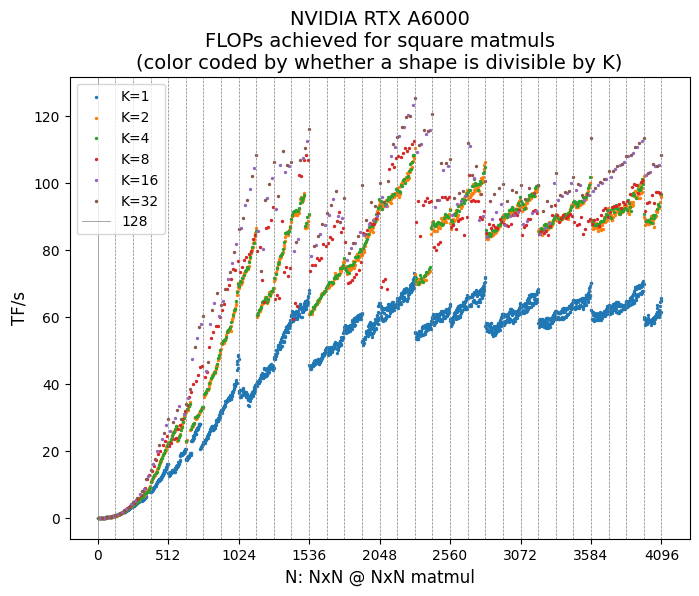

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

input_path = output_dir / f"{file_stem}.csv"
df = pd.read_csv(input_path)
xs = df["N"].values
ys = df["TFLOPS"].values

k2x = defaultdict(list)
for x in xs:
    z = x
    k = 1
    while z % 2 == 0:
        z //= 2
        k *= 2
    k2x[min(k, 32)].append(x)
ks = sorted(k2x.keys())

fig, ax = plt.subplots(figsize=(8, 6))
for k in ks:
    ax.scatter(k2x[k], ys[[x in k2x[k] for x in xs]], label=f"K={k}", s=2)

for vline in range(0, 4097, 128):
    if vline == 0:
        ax.axvline(x=vline, color='gray', linestyle='-', linewidth=0.5, label='128')
    else:
        ax.axvline(x=vline, color='gray', linestyle='--', linewidth=0.5)

xticks = np.arange(0, 4097, 512)
ax.set_xticks(xticks)
ax.tick_params(labelsize=10)

ax.set_xlabel("N: NxN @ NxN matmul", size=12)
ax.set_ylabel("TF/s", size=12)
title = f"{device_name}\n"\
        "FLOPs achieved for square matmuls\n"\
        "(color coded by whether a shape is divisible by K)"
ax.set_title(title, size=14)
ax.legend(loc='upper left')
plt.show()

output_path = output_dir / f"{file_stem}.png"
fig.savefig(output_path, bbox_inches='tight', dpi=300)
plt.close(fig)